In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test.csv
Saving train.csv to train.csv
User uploaded file "test.csv" with length 2331766 bytes
User uploaded file "train.csv" with length 4794242 bytes


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.head(10)

,Unnamed: 0,title,abstract,keywords,Cardio,Diges,Resp,Nerv,Infe
0,2463,Dementia Therapy Targeting Tau.,tau microtubul associ tau protein also non mic...,Alternative Splicing; Alzheimer Disease; Demen...,0,0,0,1,0
1,2511,[Acute neuropsychiatry: a confused patient and...,anti nmda receptor enceph progress autoimmun d...,Acute Disease; Anti-N-Methyl-D-Aspartate Recep...,0,0,0,1,0
2,2227,A systematic review and meta-analysis of safet...,safinamid recent develop drug sever mechan act...,Add-on; Dopamine; Dopamine agonist; Motor; Mov...,0,0,0,1,0
3,526,Emotional intelligence and systolic blood pres...,present studi design compar emot intellig ei c...,Hear t Failure; Mean arterial pressure; Cogni...,1,0,0,0,0
4,4291,Necrotising fasciitis caused by aeromonas sobr...,necrotis fasciiti life threaten infect soft ti...,"Aeromonas; Animals; Catfishes; Diagnosis, Diff...",0,0,0,0,1
5,2986,Development of a Sleep Apnea Detection Algorit...,sleep apnea syndrom sa preval disord caus dayt...,"Algorithms; Heart Rate; Humans; Memory, Short-...",0,0,0,1,0
6,1842,Prevalence of Cryptosporidium spp. infection a...,cryptosporidium spp identifi import caus diarr...,Child; Cross-Sectional Studies; Cryptosporidio...,0,1,0,0,0
7,1142,Awareness of smoking in adolescents with infla...,inflammatori bowel diseas ibd long life diseas...,Crohn...s disease; Ulcerative colitis; environ...,0,1,0,0,0
8,3371,Immune response during influenza virus infecti...,pathogen influenza viru infect modul cytokin e...,Cytokine; Northeast India; influenza virus; pa...,0,0,0,0,1
9,5349,Identification of Ppar<i>..</i>-modulated miRN...,liver fibrosi interfer normal liver function f...,PPAR..; fibrosis; hepatocellular carcinoma; mi...,0,0,1,0,0


In [ ]:
test_df.head(10)

,Unnamed: 0,title,abstract,keywords,Cardio,Diges,Resp,Nerv,Infe
0,3,Multi-organ trauma with rupture and Stanford t...,case year old car driver struck great forc tra...,blunt thoracic aortic injury (BTAI); lateral c...,1,0,0,0,0
1,4,Anticoagulant treatment in elderly patients wi...,atrial fibril af common elderli treatment cond...,anticoagulation therapy; atrial fibrillation; ...,1,0,0,0,0
2,6,Does characterising patterns of multimorbidity...,stroke transient ischaem attack tia remain lea...,integrated care; interprofessional collaborati...,1,0,0,0,0
3,8,Biological agent in prevention of ocular recur...,ocular involv beh et diseas bd character recur...,"Adalimumab; Administration, Oral; Adult; Anti-...",1,0,0,0,0
4,9,Lens induced glaucoma in a tertiary eye care c...,len induc glaucoma due hypermatur cataract imp...,Aged; Cataract; Cataract Extraction; Eye Pain;...,1,0,0,0,0
5,11,Ventricular bigeminy in enteric fever.,salmonella infect caus wide rang intestin extr...,Adult; Anti-Bacterial Agents; Electrocardiogra...,1,0,0,0,0
6,14,TORSADES DE POINTES IN ELDERLY PATIENT WITH PA...,one drug wide use treatment atrial fibril amio...,Amiodarone; Atrial fibrillation; Bradycardia; ...,1,0,0,0,0
7,15,Transcatheter InterAtrial Shunt Device for the...,random sham control trial patient heart failur...,Cardiac Catheterization; Double-Blind Method; ...,1,0,0,0,0
8,22,[Endothelial dysfunction in patients with cont...,conduct compar analysi level asymmetr dimethyl...,arterial hypertension; asymmetric dimethylargi...,1,0,0,0,0
9,23,[Autoantibodies to M2-cholinoreceptors as a po...,aim assess autoantibodi m2 cholinoceptor m2 cr...,M2 cholinoceptors; arterial hypertension; atri...,1,0,0,0,0


In [18]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

vocab = Counter()

def text_to_wordlist(text, lower=False):
  text = tokenizer.tokenize(text)
  text = [w for w in text if len(w) != 1]
  vocab.update(text)
  return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)

    return comments

list_sentences_train = list(train_df["keywords"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["keywords"].fillna("NAN_WORD").values)

#Todas las keywords
comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

 26%|██▋       | 1427/5417 [00:00<00:00, 14258.39it/s]

Processing text dataset


100%|██████████| 5417/5417 [00:00<00:00, 12847.12it/s]


In [ ]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 13638 unique tokens


In [4]:
!pip install glove_python

     |████████████████████████████████| 266kB 8.8MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=702574 sha256=35e8c127175de018ed5688624fec431e8c9044f08e72da2a116ae7b0cf87288d
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [19]:
import glove
from glove import Glove, Corpus

corpus = Corpus()
corpus.fit(comments, window=5)

model = Glove(no_components=100, learning_rate=0.05)
model.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [20]:
word_vectors = model.word_vectors
print("Number of word vectors: {}".format(len(word_vectors)))

Number of word vectors: 30420


In [ ]:
model.add_dictionary(corpus.dictionary)
model.most_similar('cardiovascular', 10)

[('morbimortalidad', 0.7862887525331965),
 ('event', 0.7496319181218619),
 ('cvd', 0.7408786094954469),
 ('advers', 0.6571731343756518),
 ('risk', 0.6456953090747468),
 ('benzo', 0.6301247918011827),
 ('cerebrovascular', 0.6033298411807535),
 ('incid', 0.5963839338670053),
 ('vascular', 0.5761466563365731)]

In [ ]:
# Shape of the vectors
word_vectors.shape

(30420, 100)

In [21]:
#Definimos el tamaño de los vectores. Al estar trabajando con keywords podemos escoger un tamaño que no sea muy grane
MAX_NB_WORDS = len(word_vectors)
MAX_SEQUENCE_LENGTH = 30

In [22]:
from keras.preprocessing.sequence import pad_sequences

#Diccionario con todas las palabras asignadas un i + 1. 
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

#Para cada una de las palabras de los articulos le damos su valor de word_index (en el caso de TRAIN)
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]

#Para cada una de las palabras de los articulos le damos su valor de word_index (en el caso de TEST)
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# Mediante la funcion pad_sequences recortamos los vectores de keywords a una longitud determinada, en este caso 20. 
#Ajuste del tamaño para TRAIN
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

list_classes = ["Cardio", "Diges", "Resp", "Nerv", "Infe"]
y = train_df[list_classes].values
print('Shape de los tensores training (data):', data.shape)
print('Shape de los tensores label del training (y):', y.shape)

#Ajuste del tamaño para TEST
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post",
                          truncating="post")
print('Shape de los tensores del test (test_data):', test_data.shape)

Shape de los tensores training (data): (3629, 30)
Shape de los tensores label del training (y): (3629, 5)
Shape de los tensores del test (test_data): (1788, 30)


In [ ]:
# Comprobamos la correspondencia entre ambos vectores, es decir, que tengan el mismo valor (mismo número) que en el diccionario generado (word_index)
#COMPROBACION TEST
list_sentences_test[9]

'M2 cholinoceptors; arterial hypertension; atrial fibrillation; autoantibodies; Atrial Fibrillation; Autoantibodies; Electrocardiography; Electrocardiography, Ambulatory; Humans; Hypertension'

In [ ]:
#longitud original
print(test_sequences[0])

[11817, 2332, 1293, 309, 11818, 1741, 11819, 11820, 2234, 2421, 2030, 2332, 3791, 1293, 2841, 11821, 1527, 1293, 11822, 216, 1575, 1821, 325, 3486, 325, 3790, 1038, 313, 227, 325, 313, 1, 3, 7, 2, 135, 1146, 313, 134, 24, 22, 207, 110, 126]


In [ ]:
word_index['thoracic']

2332

In [ ]:
#longitud despues del padding
test_data[0]

array([11817,  2332,  1293,   309, 11818,  1741, 11819, 11820,  2234,
        2421,  2030,  2332,  3791,  1293,  2841, 11821,  1527,  1293,
       11822,   216,  1575,  1821,   325,  3486,   325,  3790,  1038,
         313,   227,   325], dtype=int32)

In [ ]:
#COMPROBACION TRAIN
list_sentences_train[0]

'Alternative Splicing; Alzheimer Disease; Dementia; Humans; Tauopathies; tau Proteins'

In [ ]:
#longitud original
sequences[0]

[3581, 3582, 147, 9, 350, 1, 1022, 580, 40]

In [ ]:
word_index['Alternative']

In [ ]:
#longitud despues del padding
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3581,
       3582,  147,    9,  350,    1, 1022,  580,   40], dtype=int32)

In [ ]:
#ETIQUETAS
y

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

In [23]:
# Preparacion de la embedding matrix

WV_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_vectors))

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0

#hacemos la embedding matrix con los vectores del word2vec
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass 

In [24]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
import keras

#añadimos un control de forma que si se dan dos epocas sin mejorar accuracy se corta el entrenamiento y se escoge el mejor modelo. 
callbacks_list = [keras.callbacks.EarlyStopping(
                  monitor='accuracy',
                  patience=3,),
                  keras.callbacks.ModelCheckpoint(
                  filepath='my_model.h5',
                  monitor='val_loss',
                  save_best_only=True,)]

wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = LSTM(128, return_sequences=False)(embedded_sequences)

# Output
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
preds = Dense(5, activation='softmax')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='mae',
              optimizer='rmsprop',
              metrics=['accuracy']) 

In [ ]:
model.summary() 

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 30, 150)           537000    
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 30, 150)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 256)               285696    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1285      
Total params: 823,981
Trainable params: 286,981
Non-trainable params: 537,000
_________________________________________

In [25]:
LSTM_keywords_Glove = model.fit([data], y, validation_split=0.1,
                 epochs=30, batch_size=150, shuffle=True)

#val --> resultado con los test
# loss y val_loss deben tener casi el mismo valor y el mas bajo posible del orden de ~0,01
# si loss < val_loss --> overfitting
# si loss > val_loss --> underfitting 

Epoch 1/30
22/22 [==============================] - 6s 151ms/step - loss: 0.3107 - accuracy: 0.2281 - val_loss: 0.3129 - val_accuracy: 0.3388
Epoch 2/30
22/22 [==============================] - 3s 126ms/step - loss: 0.2350 - accuracy: 0.4448 - val_loss: 0.3034 - val_accuracy: 0.4325
Epoch 3/30
22/22 [==============================] - 3s 129ms/step - loss: 0.2049 - accuracy: 0.5160 - val_loss: 0.2894 - val_accuracy: 0.4628
Epoch 4/30
22/22 [==============================] - 3s 126ms/step - loss: 0.1940 - accuracy: 0.5355 - val_loss: 0.2783 - val_accuracy: 0.4821
Epoch 5/30
22/22 [==============================] - 3s 129ms/step - loss: 0.1801 - accuracy: 0.5666 - val_loss: 0.2799 - val_accuracy: 0.4848
Epoch 6/30
22/22 [==============================] - 3s 129ms/step - loss: 0.1788 - accuracy: 0.5709 - val_loss: 0.2701 - val_accuracy: 0.5041
Epoch 7/30
22/22 [==============================] - 3s 127ms/step - loss: 0.1778 - accuracy: 0.5723 - val_loss: 0.2549 - val_accuracy: 0.4876
Epoch 

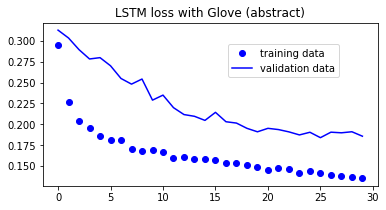

In [28]:
history = pd.DataFrame(LSTM_keywords_Glove.history)
plt.figure(figsize=(6,3));
plt.plot(history["loss"], 'bo', label='training data'); #puntos
plt.plot(history["val_loss"], 'b', label='validation data'); #linea
plt.title("LSTM loss with Glove (keywords)");
plt.legend(bbox_to_anchor=(0.9, 0.9))
plt.show();

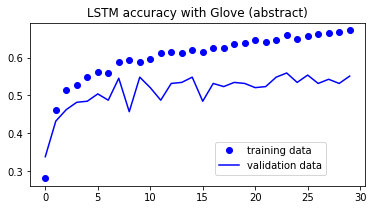

In [29]:
history = pd.DataFrame(LSTM_keywords_Glove.history)
plt.figure(figsize=(6,3));
plt.plot(history["accuracy"], 'bo', label='training data'); #puntos
plt.plot(history["val_accuracy"], 'b', label='validation data'); #linea
plt.title("LSTM accuracy with Glove (keywords)");
plt.legend(bbox_to_anchor=(0.9, 0.3))
plt.show();